In [ ]:
#@title Traducción y análisis de sentimientos

# ============================================================
# COLAB: Traducción por país + Sentiment EN
# CON MENSAJES DE PROGRESO
# ============================================================

!pip -q install pandas numpy transformers sentencepiece accelerate

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification

print("\n[INFO] Inicio del pipeline")

# ----------------------------
# 1) Cargar dataset
# ----------------------------
PATH = "replies_meta_desde_urls.csv"
df = pd.read_csv(PATH, sep=";", encoding="latin1", engine="python")

df["text"] = df["text"].astype(str).fillna("").str.replace(r"\s+", " ", regex=True).str.strip()
df["_user_original_norm"] = df["user_original"].astype(str).str.lower().str.strip()

media_to_country = {
    "@20m": "España",
    "@el_pais": "España",
    "@eldiarioes": "España",
    "@elmundoes": "España",
    "@ensonhaber": "Turquía",
    "@gazetesozcu": "Turquía",
    "@haberturk": "Turquía",
    "@nypost": "Estados Unidos",
    "@nytimes": "Estados Unidos",
    "@washingtonpost": "Estados Unidos",
    "@wsj": "Estados Unidos",
    "@usatoday": "Estados Unidos",
}
df["pais"] = df["_user_original_norm"].map(media_to_country)

mask_nonempty = df["text"].ne("")
print(f"[INFO] Total filas con texto: {mask_nonempty.sum()}")

print("\n[INFO] Distribución por país:")
print(df["pais"].value_counts(dropna=False))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n[INFO] Device: {device}")

# ----------------------------
# 2) Traducción (solo España y Turquía)
# ----------------------------
print("\n[INFO] Cargando modelo de traducción (NLLB)...")
TRANSLATION_MODEL = "facebook/nllb-200-distilled-600M"
trans_tokenizer = AutoTokenizer.from_pretrained(TRANSLATION_MODEL)
trans_model = AutoModelForSeq2SeqLM.from_pretrained(TRANSLATION_MODEL).to(device)

@torch.inference_mode()
def translate_to_english(texts, src_lang_code, label, batch_size=16, max_length=256):
    trans_tokenizer.src_lang = src_lang_code
    outputs = []
    total = len(texts)
    n_batches = (total + batch_size - 1) // batch_size

    for i in range(0, total, batch_size):
        b = i // batch_size + 1
        print(f"[TRADUCCIÓN {label}] Lote {b}/{n_batches}")
        batch = texts[i:i+batch_size]

        enc = trans_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        ).to(device)

        gen = trans_model.generate(
            **enc,
            forced_bos_token_id=trans_tokenizer.convert_tokens_to_ids("eng_Latn"),
            max_new_tokens=max_length,
            num_beams=4,
        )
        outputs.extend(trans_tokenizer.batch_decode(gen, skip_special_tokens=True))

    print(f"[TRADUCCIÓN {label}] Finalizada")
    return outputs

df["text_en"] = ""

# EEUU → copiar
mask_us = mask_nonempty & (df["pais"] == "Estados Unidos")
print(f"\n[INFO] EEUU → no se traduce: {mask_us.sum()} textos")
df.loc[mask_us, "text_en"] = df.loc[mask_us, "text"]

# España → traducir
mask_es = mask_nonempty & (df["pais"] == "España")
print(f"[INFO] España → se traducen: {mask_es.sum()} textos")
if mask_es.any():
    df.loc[mask_es, "text_en"] = translate_to_english(
        df.loc[mask_es, "text"].tolist(), "spa_Latn", label="ES"
    )

# Turquía → traducir
mask_tr = mask_nonempty & (df["pais"] == "Turquía")
print(f"[INFO] Turquía → se traducen: {mask_tr.sum()} textos")
if mask_tr.any():
    df.loc[mask_tr, "text_en"] = translate_to_english(
        df.loc[mask_tr, "text"].tolist(), "tur_Latn", label="TR"
    )

# Fallback
mask_left = mask_nonempty & df["text_en"].eq("")
df.loc[mask_left, "text_en"] = df.loc[mask_left, "text"]

print("\n[INFO] Traducción completada")

# ----------------------------
# 3) Sentiment en inglés
# ----------------------------
print("\n[INFO] Cargando modelo de sentimiento...")
SENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sent_tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL).to(device)

labels = {int(k): v.lower() for k, v in sent_model.config.id2label.items()}
neg_i = [k for k,v in labels.items() if "neg" in v][0]
pos_i = [k for k,v in labels.items() if "pos" in v][0]

@torch.inference_mode()
def sentiment_probs(texts, batch_size=32, max_length=128):
    outputs = []
    total = len(texts)
    n_batches = (total + batch_size - 1) // batch_size

    for i in range(0, total, batch_size):
        b = i // batch_size + 1
        print(f"[SENTIMENT] Lote {b}/{n_batches}")
        batch = texts[i:i+batch_size]

        enc = sent_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        ).to(device)

        logits = sent_model(**enc).logits
        outputs.append(torch.softmax(logits, dim=1).detach().cpu().numpy())

    print("[SENTIMENT] Finalizado")
    return np.vstack(outputs)

texts_en = df["text_en"].astype(str).tolist()
probs = sentiment_probs(texts_en)

df["polaridad"] = probs[:, pos_i] - probs[:, neg_i]

print("\n[INFO] Polaridad media por país:")
print(df.groupby("pais")["polaridad"].mean())

# ----------------------------
# 4) Guardar
# ----------------------------
out_path = "replies_meta_en_sentiment.csv"
df.drop(columns=["_user_original_norm"], errors="ignore").to_csv(out_path, index=False, encoding="utf-8")
print(f"\n[OK] Archivo guardado: {out_path}")



[INFO] Inicio pipeline
[INFO] Device: cpu
[INFO] Archivo: replies_meta_en_sentiment.csv

[INFO] N inicial (respuestas): 1051
[INFO] N por país (antes):
pais
Estados Unidos    756
España            290
Turquía             5
Name: count, dtype: int64

[INFO] Excluyendo Turquía del análisis principal (N=5)

[INFO] N tras excluir Turquía: 1046
[INFO] N por país (después):
pais
Estados Unidos    756
España            290
Name: count, dtype: int64

[OK] Tablas descriptivas guardadas


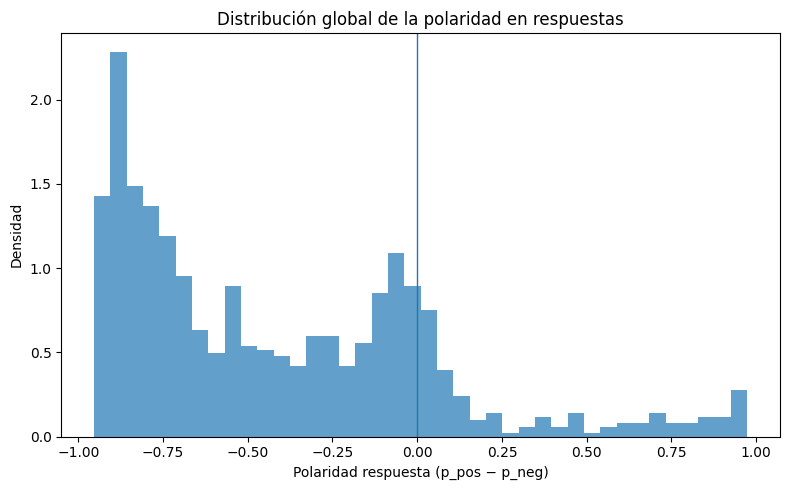

/tmp/ipython-input-1011869633.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_country, labels=country_order, showfliers=False)


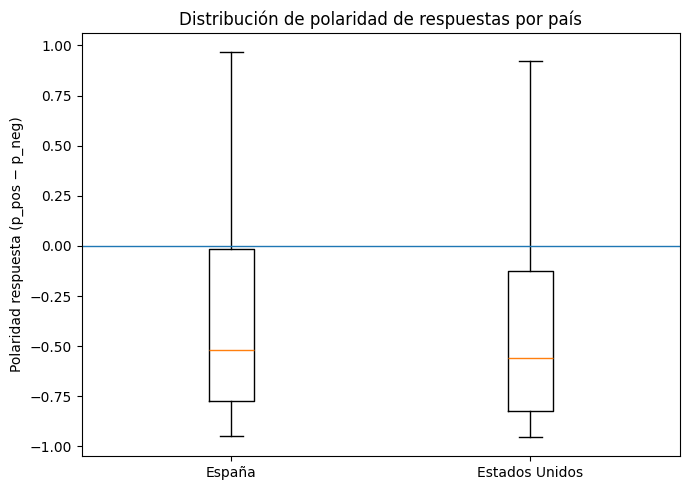

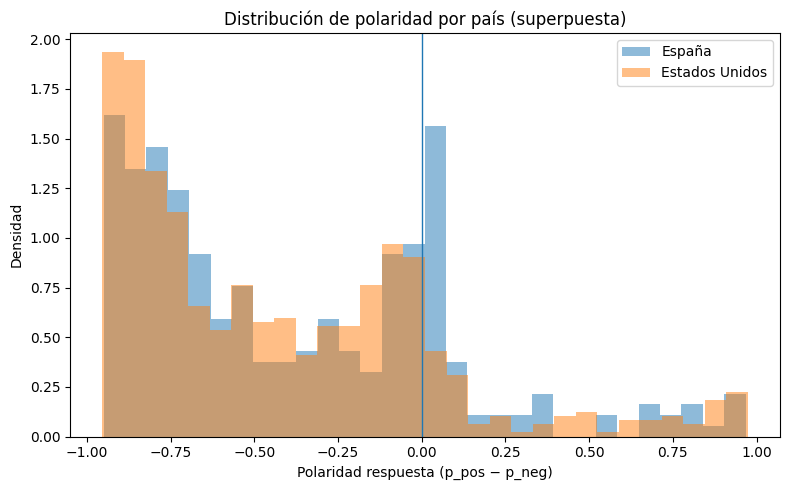

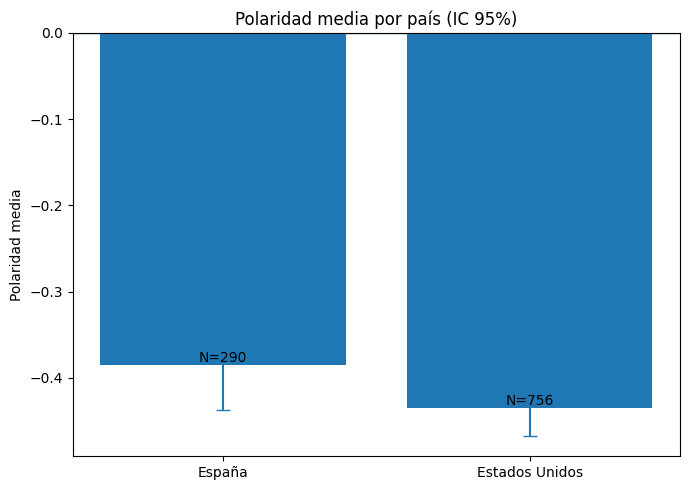

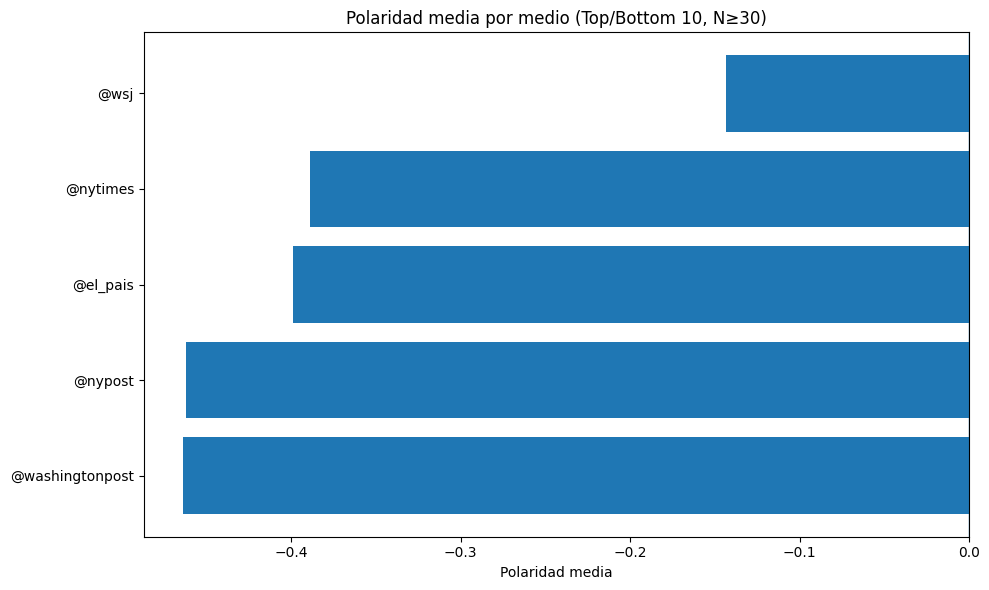


[OK] Figuras descriptivas guardadas

[INFO] Preparando titulares únicos por original_tweet_id
[INFO] Titulares únicos (sin Turquía): 46

[INFO] Cargando NLLB para traducción de titulares a inglés…


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

[TRAD TITULARES] spa_Latn lote 1/2
[TRAD TITULARES] spa_Latn lote 2/2

[INFO] Cargando RoBERTa sentiment para titulares…


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[SENT TITULARES] lote 1/2


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

[SENT TITULARES] lote 2/2

[OK] Guardado: paper_meta_titulares_polaridad.csv
[INFO] % respuestas sin pol_titular tras merge: 0.00%

[RELACIONAL] Correlaciones (nivel titular):
Pearson r = 0.032, p = 0.8312
Spearman rho = -0.123, p = 0.4169


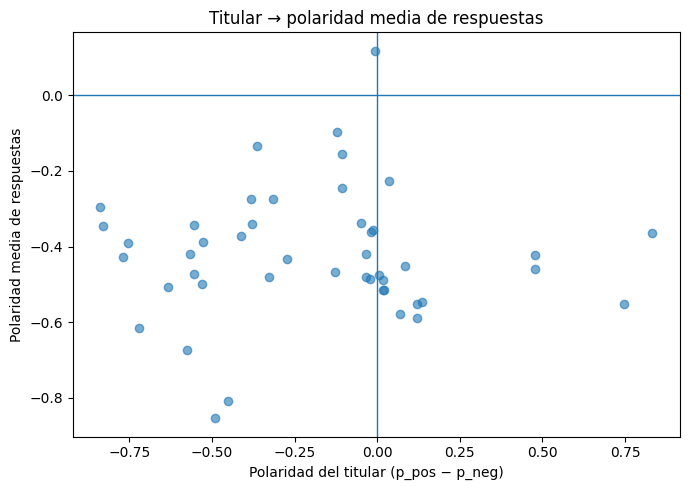


[MODELOS] Nivel titular (principal):
                            OLS Regression Results                            
Dep. Variable:          pol_resp_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                   0.04600
Date:                Fri, 30 Jan 2026   Prob (F-statistic):              0.831
Time:                        11:25:05   Log-Likelihood:                 16.553
No. Observations:                  46   AIC:                            -29.11
Df Residuals:                      44   BIC:                            -25.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '


In [1]:
# ============================================================
# COLAB PIPELINE (Paper-ready) — Meta / Censura / Políticas
# - Descriptivos + figuras (respuestas, RoBERTa ya calculado)
# - Excluir Turquía (N muy bajo)
# - Polaridad del TITULAR con el MISMO método RoBERTa:
#     1) Traducción a EN (NLLB) para titulares no-EN
#     2) Sentiment RoBERTa => pol_titular = P(pos) - P(neg)
# - Análisis relacional principal:
#     respuestas ~ pol_titular (+ controles país/medio)
#     y agregado por titular (media respuestas por titular)
# ============================================================

!pip -q install pandas numpy matplotlib scipy statsmodels transformers accelerate sentencepiece torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.formula.api as smf

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM

print("\n[INFO] Inicio pipeline")

# ----------------------------
# CONFIG
# ----------------------------
# Usa tu archivo montado aquí (si lo subiste en esta sesión)
PATH_OUT = "replies_meta_en_sentiment.csv"   # <- cambia si lo necesitas
OUT_PREFIX = "paper_meta"

# Exclusión Turquía (requerido)
EXCLUDE_TURKEY = True

# Figuras/medios
MIN_N_MEDIA = 30
TOPBOTTOM_N = 10

# Rangos interpretables de polaridad respuestas (RoBERTa)
BINS = [-1, -0.5, -0.1, 0.1, 0.5, 1]
BIN_LABELS = ["Neg. fuerte", "Neg. moderada", "Neutral", "Pos. moderada", "Pos. fuerte"]

# Modelos
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# TITULARES: traducción obligatoria (porque están en idioma original)
TRANSLATION_MODEL = "facebook/nllb-200-distilled-600M"

# Sentiment RoBERTa (mismo que usaste en respuestas)
SENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

print(f"[INFO] Device: {DEVICE}")
print(f"[INFO] Archivo: {PATH_OUT}")

# ----------------------------
# 1) Cargar datos y limpiar
# ----------------------------
df = pd.read_csv(PATH_OUT, encoding="utf-8")

# Columnas mínimas esperadas (según tu estructura)
required_cols = ["polaridad", "pais", "user_original", "original_tweet_id", "tweet_original"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas necesarias: {missing}")

# Tipos
df["polaridad"] = pd.to_numeric(df["polaridad"], errors="coerce")
df["pais"] = df["pais"].astype(str)
df["user_original"] = df["user_original"].astype(str)
df["original_tweet_id"] = df["original_tweet_id"].astype(str)

# Filtrado de respuestas válidas
dfp = df.dropna(subset=["polaridad", "pais"]).copy()
dfp = dfp[dfp["polaridad"].between(-1, 1, inclusive="both")].copy()

# Normaliza medio
dfp["medio_norm"] = dfp["user_original"].astype(str).str.strip().str.lower()

print("\n[INFO] N inicial (respuestas):", len(dfp))
print("[INFO] N por país (antes):")
print(dfp["pais"].value_counts(dropna=False))

# Excluir Turquía (análisis principal)
if EXCLUDE_TURKEY:
    n_tr = int((dfp["pais"] == "Turquía").sum())
    if n_tr > 0:
        print(f"\n[INFO] Excluyendo Turquía del análisis principal (N={n_tr})")
    dfp = dfp[dfp["pais"] != "Turquía"].copy()

print("\n[INFO] N tras excluir Turquía:", len(dfp))
print("[INFO] N por país (después):")
print(dfp["pais"].value_counts(dropna=False))

country_order = [c for c in ["España", "Estados Unidos"] if c in dfp["pais"].unique()]

# ----------------------------
# 2) DESCRIPTIVOS (paper-ready)
# ----------------------------
def desc_series(x: pd.Series):
    x = x.dropna()
    return pd.Series({
        "N": x.shape[0],
        "Mean": x.mean(),
        "SD": x.std(ddof=1),
        "Median": x.median(),
        "P25": x.quantile(0.25),
        "P75": x.quantile(0.75),
        "Min": x.min(),
        "Max": x.max(),
        "Skew": x.skew(),
        "Kurtosis": x.kurt()
    })

# Global
desc_global = desc_series(dfp["polaridad"])
# Por país
desc_country = dfp.groupby("pais")["polaridad"].apply(desc_series).unstack().reindex(country_order)
# Por medio
desc_media = dfp.groupby("medio_norm")["polaridad"].apply(desc_series).unstack().sort_values("N", ascending=False)

# Rangos interpretables
dfp["polaridad_cat"] = pd.cut(dfp["polaridad"], bins=BINS, labels=BIN_LABELS, include_lowest=True)
dist_global = (dfp["polaridad_cat"].value_counts(normalize=True).reindex(BIN_LABELS) * 100).round(2)

dist_country = (
    dfp.groupby("pais")["polaridad_cat"]
       .value_counts(normalize=True)
       .rename("pct")
       .reset_index()
)
dist_country["pct"] = (dist_country["pct"] * 100).round(2)

# Guardar tablas
desc_global.to_frame("global").to_csv(f"{OUT_PREFIX}_desc_global.csv", encoding="utf-8")
desc_country.to_csv(f"{OUT_PREFIX}_desc_por_pais.csv", encoding="utf-8")
desc_media.to_csv(f"{OUT_PREFIX}_desc_por_medio.csv", encoding="utf-8")
dist_global.to_frame("pct").to_csv(f"{OUT_PREFIX}_dist_global_bins.csv", encoding="utf-8")
dist_country.to_csv(f"{OUT_PREFIX}_dist_pais_bins.csv", index=False, encoding="utf-8")

print("\n[OK] Tablas descriptivas guardadas")

# ----------------------------
# 3) FIGURAS (300 dpi)
# ----------------------------

# 3.1 Histograma global
plt.figure(figsize=(8,5))
plt.hist(dfp["polaridad"].values, bins=40, density=True, alpha=0.7)
plt.axvline(0, linewidth=1)
plt.xlabel("Polaridad respuesta (p_pos − p_neg)")
plt.ylabel("Densidad")
plt.title("Distribución global de la polaridad en respuestas")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig1_hist_global.png", dpi=300)
plt.show()

# 3.2 Boxplot por país
data_by_country = [dfp.loc[dfp["pais"] == c, "polaridad"].values for c in country_order]
plt.figure(figsize=(7,5))
plt.boxplot(data_by_country, labels=country_order, showfliers=False)
plt.axhline(0, linewidth=1)
plt.ylabel("Polaridad respuesta (p_pos − p_neg)")
plt.title("Distribución de polaridad de respuestas por país")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig2_boxplot_pais.png", dpi=300)
plt.show()

# 3.3 Histogramas superpuestos por país
plt.figure(figsize=(8,5))
for c in country_order:
    vals = dfp.loc[dfp["pais"] == c, "polaridad"].values
    plt.hist(vals, bins=30, alpha=0.5, density=True, label=c)
plt.axvline(0, linewidth=1)
plt.xlabel("Polaridad respuesta (p_pos − p_neg)")
plt.ylabel("Densidad")
plt.title("Distribución de polaridad por país (superpuesta)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig3_hist_pais.png", dpi=300)
plt.show()

# 3.4 Medias por país con IC 95%
means = dfp.groupby("pais")["polaridad"].mean().reindex(country_order)
counts = dfp.groupby("pais")["polaridad"].count().reindex(country_order)
sds = dfp.groupby("pais")["polaridad"].std(ddof=1).reindex(country_order)
se = sds / np.sqrt(counts)
ci_low = means - 1.96*se
ci_high = means + 1.96*se

plt.figure(figsize=(7,5))
plt.bar(means.index, means.values)
plt.errorbar(
    x=np.arange(len(means.index)),
    y=means.values,
    yerr=[means.values - ci_low.values, ci_high.values - means.values],
    fmt="none",
    capsize=5
)
plt.axhline(0, linewidth=1)
plt.ylabel("Polaridad media")
plt.title("Polaridad media por país (IC 95%)")
for i, c in enumerate(means.index):
    plt.text(i, means.values[i], f"N={int(counts[c])}", ha="center", va="bottom")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig4_media_pais_ic.png", dpi=300)
plt.show()

# 3.5 Medias por medio (Top/Bottom, N≥MIN_N_MEDIA)
n_media = dfp["medio_norm"].value_counts()
keep_media = n_media[n_media >= MIN_N_MEDIA].index
means_media = dfp.groupby("medio_norm")["polaridad"].mean().loc[keep_media].sort_values()

bottom = means_media.head(TOPBOTTOM_N)
top = means_media.tail(TOPBOTTOM_N)
combo = pd.concat([bottom, top])

plt.figure(figsize=(10,6))
plt.barh(combo.index, combo.values)
plt.axvline(0, linewidth=1)
plt.xlabel("Polaridad media")
plt.title(f"Polaridad media por medio (Top/Bottom {TOPBOTTOM_N}, N≥{MIN_N_MEDIA})")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig5_media_medio_topbottom.png", dpi=300)
plt.show()

print("\n[OK] Figuras descriptivas guardadas")

# ----------------------------
# 4) TITULARES: Traducción a EN + RoBERTa (p_pos - p_neg)
# ----------------------------
print("\n[INFO] Preparando titulares únicos por original_tweet_id")

head = (
    dfp[["original_tweet_id", "tweet_original", "pais", "medio_norm"]]
    .dropna(subset=["original_tweet_id", "tweet_original"])
    .drop_duplicates(subset=["original_tweet_id"])
    .copy()
)

head["tweet_original"] = head["tweet_original"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
head = head[head["tweet_original"].ne("")].copy()

print(f"[INFO] Titulares únicos (sin Turquía): {len(head)}")

print("\n[INFO] Cargando NLLB para traducción de titulares a inglés…")
trans_tokenizer = AutoTokenizer.from_pretrained(TRANSLATION_MODEL)
trans_model = AutoModelForSeq2SeqLM.from_pretrained(TRANSLATION_MODEL).to(DEVICE)

@torch.inference_mode()
def translate_to_english(texts, src_lang_code, batch_size=16, max_length=256):
    trans_tokenizer.src_lang = src_lang_code
    outs = []
    total = len(texts)
    n_batches = (total + batch_size - 1) // batch_size
    for i in range(0, total, batch_size):
        b = i // batch_size + 1
        print(f"[TRAD TITULARES] {src_lang_code} lote {b}/{n_batches}")
        batch = texts[i:i+batch_size]
        enc = trans_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(DEVICE)
        gen = trans_model.generate(
            **enc,
            forced_bos_token_id=trans_tokenizer.convert_tokens_to_ids("eng_Latn"),
            max_new_tokens=max_length,
            num_beams=4,
        )
        outs.extend(trans_tokenizer.batch_decode(gen, skip_special_tokens=True))
    return outs

# Traducción por país: EEUU copia, España traduce
head["tweet_original_en"] = ""

m_us = head["pais"].eq("Estados Unidos")
head.loc[m_us, "tweet_original_en"] = head.loc[m_us, "tweet_original"]

m_es = head["pais"].eq("España")
if m_es.any():
    head.loc[m_es, "tweet_original_en"] = translate_to_english(
        head.loc[m_es, "tweet_original"].tolist(), "spa_Latn"
    )

# Fallback (por seguridad)
left = head["tweet_original_en"].astype(str).str.strip().eq("")
head.loc[left, "tweet_original_en"] = head.loc[left, "tweet_original"]

print("\n[INFO] Cargando RoBERTa sentiment para titulares…")
sent_tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL).to(DEVICE)

labels = {int(k): v.lower() for k, v in sent_model.config.id2label.items()}
neg_i = [k for k, v in labels.items() if "neg" in v][0]
pos_i = [k for k, v in labels.items() if "pos" in v][0]

@torch.inference_mode()
def sentiment_probs(texts, batch_size=32, max_length=128):
    all_probs = []
    total = len(texts)
    n_batches = (total + batch_size - 1) // batch_size
    for i in range(0, total, batch_size):
        b = i // batch_size + 1
        print(f"[SENT TITULARES] lote {b}/{n_batches}")
        batch = texts[i:i+batch_size]
        enc = sent_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(DEVICE)
        logits = sent_model(**enc).logits
        probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.vstack(all_probs)

headline_texts = head["tweet_original_en"].astype(str).tolist()
probs_h = sentiment_probs(headline_texts)

head["pol_titular"] = probs_h[:, pos_i] - probs_h[:, neg_i]

# Guardar titulares
head.to_csv(f"{OUT_PREFIX}_titulares_polaridad.csv", index=False, encoding="utf-8")
print(f"\n[OK] Guardado: {OUT_PREFIX}_titulares_polaridad.csv")

# Merge pol_titular a respuestas
dfp = dfp.merge(head[["original_tweet_id", "pol_titular"]], on="original_tweet_id", how="left")
miss = dfp["pol_titular"].isna().mean() * 100
print(f"[INFO] % respuestas sin pol_titular tras merge: {miss:.2f}%")

# ----------------------------
# 5) ANÁLISIS RELACIONAL (principal)
# ----------------------------

# 5.1 Agregado por titular (más conservador y muy defendible)
agg = (
    dfp.groupby("original_tweet_id")
       .agg(
           pol_resp_mean=("polaridad", "mean"),
           pol_resp_sd=("polaridad", "std"),
           n_resp=("polaridad", "size"),
           pol_titular=("pol_titular", "first"),
           pais=("pais", "first"),
           medio_norm=("medio_norm", "first")
       )
       .reset_index()
)
agg = agg.dropna(subset=["pol_titular", "pol_resp_mean"])

# Correlaciones
pear = stats.pearsonr(agg["pol_titular"], agg["pol_resp_mean"])
spear = stats.spearmanr(agg["pol_titular"], agg["pol_resp_mean"])

print("\n[RELACIONAL] Correlaciones (nivel titular):")
print(f"Pearson r = {pear.statistic:.3f}, p = {pear.pvalue:.4f}")
print(f"Spearman rho = {spear.statistic:.3f}, p = {spear.pvalue:.4f}")

# Scatter
plt.figure(figsize=(7,5))
plt.scatter(agg["pol_titular"], agg["pol_resp_mean"], alpha=0.6)
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("Polaridad del titular (p_pos − p_neg)")
plt.ylabel("Polaridad media de respuestas")
plt.title("Titular → polaridad media de respuestas")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig6_scatter_titular_vs_respmean.png", dpi=300)
plt.show()

# Modelos (principal): con controles
m1 = smf.ols("pol_resp_mean ~ pol_titular", data=agg).fit()
m2 = smf.ols("pol_resp_mean ~ pol_titular + C(pais) + C(medio_norm)", data=agg).fit()

print("\n[MODELOS] Nivel titular (principal):")
print(m1.summary())
print(m2.summary())

# Guardar resúmenes compactos
models_title = pd.DataFrame({
    "model": ["m1", "m2"],
    "n_obs": [int(m1.nobs), int(m2.nobs)],
    "coef_pol_titular": [m1.params.get("pol_titular", np.nan), m2.params.get("pol_titular", np.nan)],
    "se_pol_titular": [m1.bse.get("pol_titular", np.nan), m2.bse.get("pol_titular", np.nan)],
    "p_pol_titular": [m1.pvalues.get("pol_titular", np.nan), m2.pvalues.get("pol_titular", np.nan)],
    "r2": [m1.rsquared, m2.rsquared]
})
models_title.to_csv(f"{OUT_PREFIX}_modelos_nivel_titular_resumen.csv", index=False, encoding="utf-8")

# 5.2 Nivel respuesta (robusto), SE cluster por titular
df_mod = dfp.dropna(subset=["pol_titular", "polaridad"]).copy()

m3 = smf.ols("polaridad ~ pol_titular", data=df_mod).fit(
    cov_type="cluster", cov_kwds={"groups": df_mod["original_tweet_id"]}
)
m4 = smf.ols("polaridad ~ pol_titular + C(pais) + C(medio_norm)", data=df_mod).fit(
    cov_type="cluster", cov_kwds={"groups": df_mod["original_tweet_id"]}
)

print("\n[MODELOS] Nivel respuesta (SE cluster por titular):")
print(m3.summary())
print(m4.summary())

models_resp = pd.DataFrame({
    "model": ["m3_cluster", "m4_cluster"],
    "n_obs": [int(m3.nobs), int(m4.nobs)],
    "coef_pol_titular": [m3.params.get("pol_titular", np.nan), m4.params.get("pol_titular", np.nan)],
    "se_pol_titular": [m3.bse.get("pol_titular", np.nan), m4.bse.get("pol_titular", np.nan)],
    "p_pol_titular": [m3.pvalues.get("pol_titular", np.nan), m4.pvalues.get("pol_titular", np.nan)],
    "r2": [m3.rsquared, m4.rsquared]
})
models_resp.to_csv(f"{OUT_PREFIX}_modelos_nivel_respuesta_cluster_resumen.csv", index=False, encoding="utf-8")

# Guardar datasets finales
dfp.to_csv(f"{OUT_PREFIX}_dataset_final_con_titulares.csv", index=False, encoding="utf-8")
agg.to_csv(f"{OUT_PREFIX}_agg_por_titular.csv", index=False, encoding="utf-8")

print("\n✅ OUTPUTS principales:")
print([
    f"{OUT_PREFIX}_desc_global.csv",
    f"{OUT_PREFIX}_desc_por_pais.csv",
    f"{OUT_PREFIX}_desc_por_medio.csv",
    f"{OUT_PREFIX}_dist_global_bins.csv",
    f"{OUT_PREFIX}_titulares_polaridad.csv",
    f"{OUT_PREFIX}_modelos_nivel_titular_resumen.csv",
    f"{OUT_PREFIX}_modelos_nivel_respuesta_cluster_resumen.csv",
    f"{OUT_PREFIX}_dataset_final_con_titulares.csv",
    f"{OUT_PREFIX}_agg_por_titular.csv",
    f"{OUT_PREFIX}_fig1_hist_global.png",
    f"{OUT_PREFIX}_fig2_boxplot_pais.png",
    f"{OUT_PREFIX}_fig5_media_medio_topbottom.png",
    f"{OUT_PREFIX}_fig6_scatter_titular_vs_respmean.png",
])

In [2]:
# ============================================================
# ANÁLISIS SIMPLE POR TITULAR
#   - Terciles de polaridad del titular
#   - Comparación de polaridad de respuestas
#   - Kruskal–Wallis + tamaño de efecto
# ============================================================

!pip -q install pandas numpy scipy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# ----------------------------
# CONFIG
# ----------------------------
PATH = "paper_meta_dataset_final_con_titulares.csv"  # cambia si el nombre difiere
OUT_PREFIX = "paper_meta_terciles"

# ----------------------------
# 1) Cargar dataset final
# ----------------------------
df = pd.read_csv(PATH, encoding="utf-8")

# Comprobación básica
required_cols = ["original_tweet_id", "polaridad", "pol_titular"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# ----------------------------
# 2) Agregar por titular
# ----------------------------
agg = (
    df.groupby("original_tweet_id")
      .agg(
          pol_resp_mean=("polaridad", "mean"),
          pol_resp_median=("polaridad", "median"),
          pol_resp_sd=("polaridad", "std"),
          n_resp=("polaridad", "size"),
          pol_titular=("pol_titular", "first")
      )
      .reset_index()
)

# Filtrar titulares con al menos 5 respuestas (opcional pero recomendable)
agg = agg[agg["n_resp"] >= 5].copy()

print(f"[INFO] Titulares incluidos tras filtro N>=5: {len(agg)}")

[INFO] Titulares incluidos tras filtro N>=5: 40


In [3]:
# ----------------------------
# 3) Crear terciles de polaridad del titular
# ----------------------------
agg["tercil_titular"] = pd.qcut(
    agg["pol_titular"],
    q=3,
    labels=["Titulares negativos", "Titulares neutros", "Titulares positivos"]
)

print("\n[INFO] Distribución de titulares por tercil:")
print(agg["tercil_titular"].value_counts())


[INFO] Distribución de titulares por tercil:
tercil_titular
Titulares positivos    14
Titulares negativos    13
Titulares neutros      13
Name: count, dtype: int64


In [4]:
# ----------------------------
# 4) Descriptivos por tercil
# ----------------------------
desc_tercil = (
    agg.groupby("tercil_titular")
       .agg(
           N_titulares=("original_tweet_id", "count"),
           Media_respuestas=("pol_resp_mean", "mean"),
           Mediana_respuestas=("pol_resp_mean", "median"),
           SD_respuestas=("pol_resp_mean", "std"),
           Min=("pol_resp_mean", "min"),
           Max=("pol_resp_mean", "max")
       )
)

print("\n[DESCRIPTIVOS] Polaridad media de respuestas por tercil:")
print(desc_tercil)

# Guardar tabla
desc_tercil.to_csv(f"{OUT_PREFIX}_descriptivos_por_tercil.csv", encoding="utf-8")


[DESCRIPTIVOS] Polaridad media de respuestas por tercil:
                     N_titulares  Media_respuestas  Mediana_respuestas  \
tercil_titular                                                           
Titulares negativos           13         -0.429233           -0.391494   
Titulares neutros             13         -0.345046           -0.361067   
Titulares positivos           14         -0.431455           -0.481341   

                     SD_respuestas       Min       Max  
tercil_titular                                          
Titulares negativos       0.120166 -0.674137 -0.275660  
Titulares neutros         0.139048 -0.484616 -0.097132  
Titulares positivos       0.182871 -0.587738  0.117366  


/tmp/ipython-input-1449835798.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg.groupby("tercil_titular")


In [5]:
# ----------------------------
# 5) Kruskal–Wallis
# ----------------------------
groups = [
    agg.loc[agg["tercil_titular"] == label, "pol_resp_mean"].values
    for label in ["Titulares negativos", "Titulares neutros", "Titulares positivos"]
]

kw_stat, kw_p = kruskal(*groups)

print("\n[KRUSKAL–WALLIS]")
print(f"H = {kw_stat:.3f}")
print(f"p-value = {kw_p:.4f}")


[KRUSKAL–WALLIS]
H = 4.988
p-value = 0.0826


In [6]:
# ----------------------------
# 6) Tamaño de efecto (epsilon cuadrado)
# ----------------------------
N = agg.shape[0]
k = 3  # número de grupos

epsilon_sq = (kw_stat - k + 1) / (N - k)

print("\n[TAMAÑO DE EFECTO]")
print(f"Epsilon² = {epsilon_sq:.4f}")


[TAMAÑO DE EFECTO]
Epsilon² = 0.0808


/tmp/ipython-input-2810744854.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


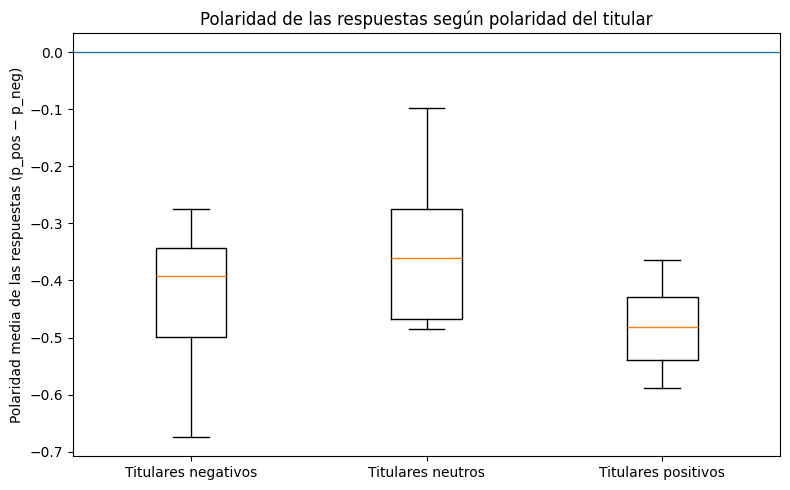

In [7]:
# ----------------------------
# 7) Boxplot por tercil (FIGURA CLAVE)
# ----------------------------
order = ["Titulares negativos", "Titulares neutros", "Titulares positivos"]
data = [agg.loc[agg["tercil_titular"] == o, "pol_resp_mean"].values for o in order]

plt.figure(figsize=(8,5))
plt.boxplot(data, labels=order, showfliers=False)
plt.axhline(0, linewidth=1)
plt.ylabel("Polaridad media de las respuestas (p_pos − p_neg)")
plt.title("Polaridad de las respuestas según polaridad del titular")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig_boxplot_terciles.png", dpi=300)
plt.show()

In [8]:
# ----------------------------
# 8) Titulares extremos (top/bottom)
# ----------------------------
top_neg = agg.sort_values("pol_resp_mean").head(5)
top_pos = agg.sort_values("pol_resp_mean").tail(5)

extremos = pd.concat([top_neg, top_pos])
extremos.to_csv(f"{OUT_PREFIX}_titulares_extremos.csv", index=False, encoding="utf-8")

print("\n[OK] Titulares extremos guardados")


[OK] Titulares extremos guardados


In [9]:
agg["intensidad_titular"] = agg["pol_titular"].abs()

[INFO] Respuestas válidas: 1046
[INFO] Titulares incluidos (N respuestas ≥ 5): 40

[INFO] Distribución de titulares por tercil de intensidad:
tercil_intensidad
Media intensidad    14
Baja intensidad     13
Alta intensidad     13
Name: count, dtype: int64

[DESCRIPTIVOS] Respuestas por tercil de intensidad:
                   N_titulares  Media_pol_resp  Mediana_pol_resp  SD_pol_resp  \
tercil_intensidad                                                               
Baja intensidad             13       -0.384537         -0.451809     0.172859   
Media intensidad            14       -0.373301         -0.427085     0.162286   
Alta intensidad             13       -0.452370         -0.428979     0.113494   

                        Min       Max  Media_intensidad  Mediana_intensidad  
tercil_intensidad                                                            
Baja intensidad   -0.516201  0.117366          0.027671            0.020635  
Media intensidad  -0.587738 -0.097132          0.266

/tmp/ipython-input-3013222012.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg.groupby("tercil_intensidad")
/tmp/ipython-input-3013222012.py:138: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


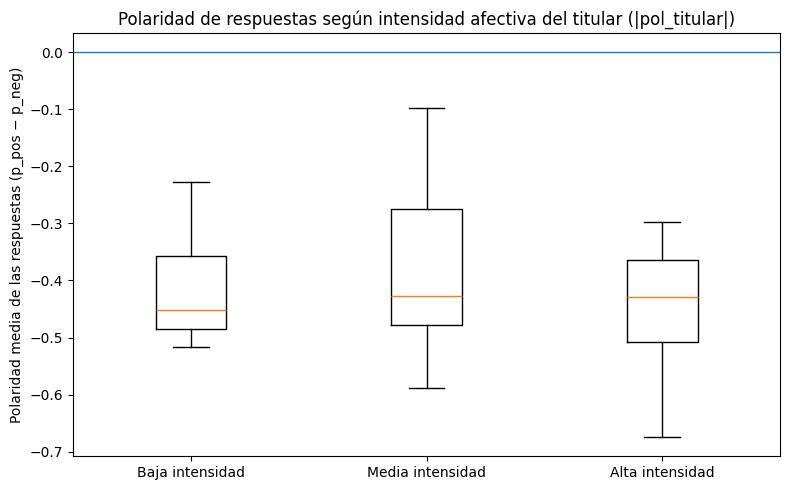


[CORRELACIONES] intensidad_titular vs pol_resp_mean (nivel titular)
Pearson r = -0.144, p = 0.3763
Spearman rho = -0.032, p = 0.8437


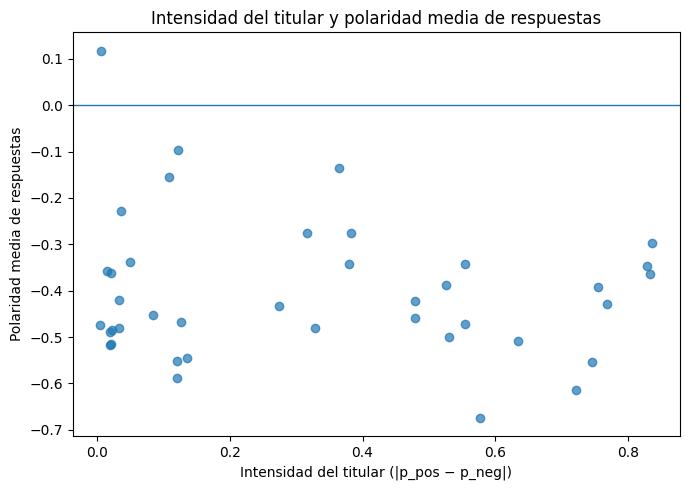


✅ Archivos guardados:
['paper_meta_intensidad_descriptivos_por_tercil_intensidad.csv', 'paper_meta_intensidad_kruskal_resultados.csv', 'paper_meta_intensidad_fig_boxplot_intensidad.png', 'paper_meta_intensidad_fig_scatter_intensidad.png', 'paper_meta_intensidad_agg_por_titular_intensidad.csv']


In [10]:
# ============================================================
# ANÁLISIS POR INTENSIDAD DEL TITULAR (|pol_titular|)
#   - Terciles de intensidad: baja / media / alta
#   - Kruskal–Wallis + tamaño de efecto (epsilon²)
#   - Figuras paper-ready (300 dpi)
# ============================================================

!pip -q install pandas numpy scipy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, spearmanr, pearsonr

# ----------------------------
# CONFIG
# ----------------------------
PATH = "paper_meta_dataset_final_con_titulares.csv"  # cambia si tu archivo se llama distinto
OUT_PREFIX = "paper_meta_intensidad"

MIN_REPLIES_PER_HEADLINE = 5   # mismo criterio que usaste antes

# ----------------------------
# 1) Cargar dataset final (nivel respuesta)
# ----------------------------
df = pd.read_csv(PATH, encoding="utf-8")

# Comprobación mínima
required = ["original_tweet_id", "polaridad", "pol_titular"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# Tipos
df["polaridad"] = pd.to_numeric(df["polaridad"], errors="coerce")
df["pol_titular"] = pd.to_numeric(df["pol_titular"], errors="coerce")
df["original_tweet_id"] = df["original_tweet_id"].astype(str)

# Limpieza
df = df.dropna(subset=["polaridad", "pol_titular", "original_tweet_id"]).copy()
df = df[df["polaridad"].between(-1, 1, inclusive="both")].copy()
df = df[df["pol_titular"].between(-1, 1, inclusive="both")].copy()

print(f"[INFO] Respuestas válidas: {len(df)}")

# ----------------------------
# 2) Agregado por titular
# ----------------------------
agg = (
    df.groupby("original_tweet_id")
      .agg(
          pol_resp_mean=("polaridad", "mean"),
          pol_resp_median=("polaridad", "median"),
          pol_resp_sd=("polaridad", "std"),
          n_resp=("polaridad", "size"),
          pol_titular=("pol_titular", "first")
      )
      .reset_index()
)

# Filtrar titulares con N mínimo de respuestas
agg = agg[agg["n_resp"] >= MIN_REPLIES_PER_HEADLINE].copy()

print(f"[INFO] Titulares incluidos (N respuestas ≥ {MIN_REPLIES_PER_HEADLINE}): {len(agg)}")

# ----------------------------
# 3) Variable clave: intensidad del titular
# ----------------------------
agg["intensidad_titular"] = agg["pol_titular"].abs()

# Crear terciles de intensidad
agg["tercil_intensidad"] = pd.qcut(
    agg["intensidad_titular"],
    q=3,
    labels=["Baja intensidad", "Media intensidad", "Alta intensidad"]
)

print("\n[INFO] Distribución de titulares por tercil de intensidad:")
print(agg["tercil_intensidad"].value_counts())

# ----------------------------
# 4) Descriptivos por tercil de intensidad
# ----------------------------
desc_int = (
    agg.groupby("tercil_intensidad")
       .agg(
           N_titulares=("original_tweet_id", "count"),
           Media_pol_resp=("pol_resp_mean", "mean"),
           Mediana_pol_resp=("pol_resp_mean", "median"),
           SD_pol_resp=("pol_resp_mean", "std"),
           Min=("pol_resp_mean", "min"),
           Max=("pol_resp_mean", "max"),
           Media_intensidad=("intensidad_titular", "mean"),
           Mediana_intensidad=("intensidad_titular", "median")
       )
)

print("\n[DESCRIPTIVOS] Respuestas por tercil de intensidad:")
print(desc_int)

desc_int.to_csv(f"{OUT_PREFIX}_descriptivos_por_tercil_intensidad.csv", encoding="utf-8")

# ----------------------------
# 5) Kruskal–Wallis (sobre pol_resp_mean por terciles de intensidad)
# ----------------------------
order = ["Baja intensidad", "Media intensidad", "Alta intensidad"]
groups = [agg.loc[agg["tercil_intensidad"] == o, "pol_resp_mean"].values for o in order]

kw_stat, kw_p = kruskal(*groups)

print("\n[KRUSKAL–WALLIS]")
print(f"H = {kw_stat:.3f}")
print(f"p-value = {kw_p:.4f}")

# Tamaño de efecto epsilon²
N = agg.shape[0]
k = 3
epsilon_sq = (kw_stat - k + 1) / (N - k)

print("\n[TAMAÑO DE EFECTO]")
print(f"Epsilon² = {epsilon_sq:.4f}")

# Guardar resultados del test
pd.DataFrame([{
    "H": kw_stat,
    "p_value": kw_p,
    "epsilon_sq": epsilon_sq,
    "N_headlines": N,
    "min_replies_per_headline": MIN_REPLIES_PER_HEADLINE
}]).to_csv(f"{OUT_PREFIX}_kruskal_resultados.csv", index=False, encoding="utf-8")

# ----------------------------
# 6) Figura principal: boxplot por intensidad (paper-ready)
# ----------------------------
data = [agg.loc[agg["tercil_intensidad"] == o, "pol_resp_mean"].values for o in order]

plt.figure(figsize=(8,5))
plt.boxplot(data, labels=order, showfliers=False)
plt.axhline(0, linewidth=1)
plt.ylabel("Polaridad media de las respuestas (p_pos − p_neg)")
plt.title("Polaridad de respuestas según intensidad afectiva del titular (|pol_titular|)")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig_boxplot_intensidad.png", dpi=300)
plt.show()

# ----------------------------
# 7) Complementario: correlación + scatter (intensidad continua)
# ----------------------------
pear = pearsonr(agg["intensidad_titular"], agg["pol_resp_mean"])
spear = spearmanr(agg["intensidad_titular"], agg["pol_resp_mean"])

print("\n[CORRELACIONES] intensidad_titular vs pol_resp_mean (nivel titular)")
print(f"Pearson r = {pear.statistic:.3f}, p = {pear.pvalue:.4f}")
print(f"Spearman rho = {spear.statistic:.3f}, p = {spear.pvalue:.4f}")

plt.figure(figsize=(7,5))
plt.scatter(agg["intensidad_titular"], agg["pol_resp_mean"], alpha=0.7)
plt.axhline(0, linewidth=1)
plt.xlabel("Intensidad del titular (|p_pos − p_neg|)")
plt.ylabel("Polaridad media de respuestas")
plt.title("Intensidad del titular y polaridad media de respuestas")
plt.tight_layout()
plt.savefig(f"{OUT_PREFIX}_fig_scatter_intensidad.png", dpi=300)
plt.show()

# ----------------------------
# 8) Guardar dataset agregado por titular
# ----------------------------
agg.to_csv(f"{OUT_PREFIX}_agg_por_titular_intensidad.csv", index=False, encoding="utf-8")

print("\n✅ Archivos guardados:")
print([
    f"{OUT_PREFIX}_descriptivos_por_tercil_intensidad.csv",
    f"{OUT_PREFIX}_kruskal_resultados.csv",
    f"{OUT_PREFIX}_fig_boxplot_intensidad.png",
    f"{OUT_PREFIX}_fig_scatter_intensidad.png",
    f"{OUT_PREFIX}_agg_por_titular_intensidad.csv"
])